In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

In [2]:
TRAIN_PATH = '../input/fruits-fresh-and-rotten-for-classification/dataset/train/'
TEST_PATH = '../input/fruits-fresh-and-rotten-for-classification/dataset/test/'
SIZE = (240, 240)

In [3]:
labels = []
for class_ in os.listdir(TRAIN_PATH):
    labels.append(class_)
NUM_LABELS = len(labels)

print(labels)

['rottenbanana', 'freshoranges', 'rottenoranges', 'freshbanana', 'rottenapples', 'freshapples']


In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255, validation_split = 0.1)
test_datagen = ImageDataGenerator(rescale=1./255) 

'''
Comments:
- ImageDataGenerator will resize all images to target_size
- x_col is the column where the images' names are
- y_col is the column where the labels are
- has_ext means that the images' names include a file extension, e.g. image_name.jpg
- Here you can change the targe_size to resize all images to different shapes.
Maybe larger images help in getting a better accuracy
'''
train_dataset = datagen.flow_from_directory(batch_size=32,
                                                 directory=TRAIN_PATH,
                                                 shuffle=True,
                                                classes=labels,
                                                 target_size=SIZE, 
                                                 subset="training",
                                                 class_mode='categorical')

val_dataset = datagen.flow_from_directory(batch_size=32,
                                                 directory=TEST_PATH ,
                                                 shuffle=True,
                                                classes=labels,
                                                 target_size=SIZE, 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 9813 images belonging to 6 classes.
Found 268 images belonging to 6 classes.


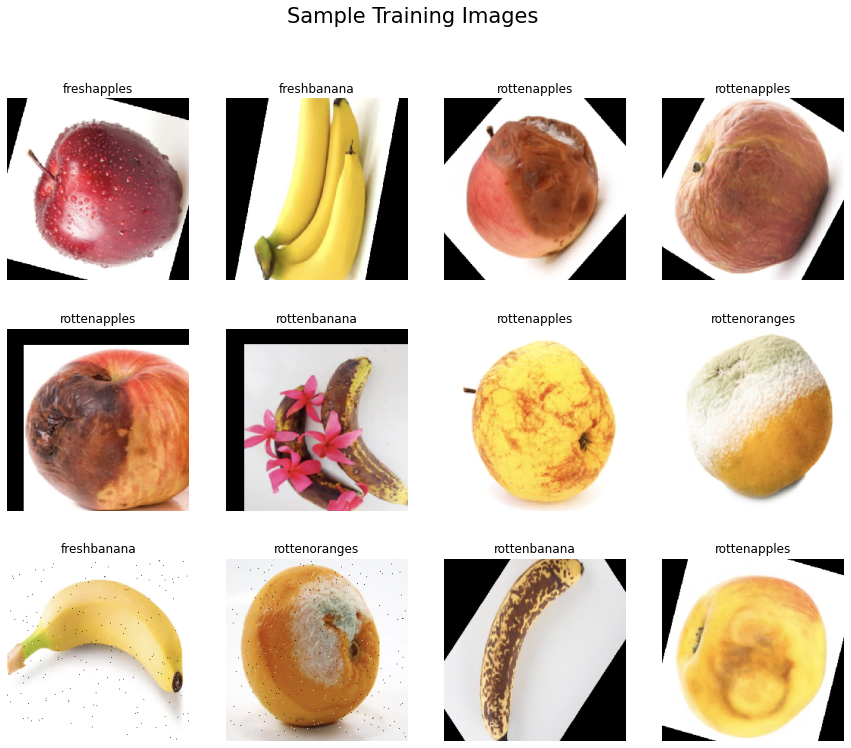

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
idx = 0

for i in range(3):
    for j in range(4):
        label = labels[np.argmax(train_dataset[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_dataset[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

# plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [6]:
from keras.applications.densenet import DenseNet121

In [7]:
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import  Adam


In [8]:
model = DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=Input(shape=(224, 224, 3)),
    input_shape=None,
    pooling=None,
    classes=6,
)


In [9]:

from keras.callbacks import LearningRateScheduler

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [11]:
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()
epochs = 20
stepsperepoch=187
validationsteps=1
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=100)
mc = ModelCheckpoint("densenet121.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [12]:
hist = model.fit_generator(
    train_dataset,
    epochs=epochs,
    callbacks=[annealer,mc,es],
    steps_per_epoch=stepsperepoch,
    validation_data=val_dataset,
    validation_steps = validationsteps
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
187/187 [==============================] - 109s 466ms/step - loss: 0.6060 - accuracy: 0.7954 - val_loss: 4.4026 - val_accuracy: 0.1875

Epoch 00001: val_loss improved from inf to 4.40257, saving model to densenet121.h5
Epoch 2/20
187/187 [==============================] - 78s 417ms/step - loss: 0.4087 - accuracy: 0.8570 - val_loss: 4.5284 - val_accuracy: 0.1875

Epoch 00002: val_loss did not improve from 4.40257
Epoch 3/20
187/187 [==============================] - 78s 415ms/step - loss: 0.3163 - accuracy: 0.8883 - val_loss: 1.1824 - val_accuracy: 0.6875

Epoch 00003: val_loss improved from 4.40257 to 1.18244, saving model to densenet121.h5
Epoch 4/20
187/187 [==============================] - 78s 417ms/step - loss: 0.2780 - accuracy: 0.9016 - val_loss: 0.4832 - val_accuracy: 0.7812

Epoch 00004: val_loss improved from 1.18244 to 0.48317, saving model to densenet121.h5
Epoch 5/20
187/187 [==============================] - 78s 415ms/step - loss: 0.2340 - accuracy: 0.9158 - va

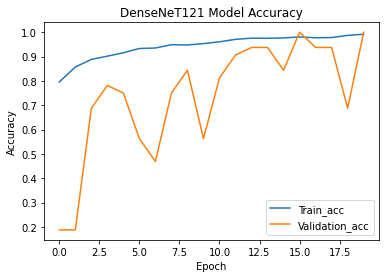

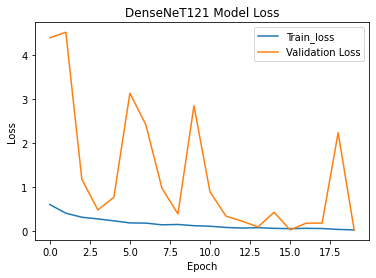

In [13]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('DenseNeT121 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Train_acc","Validation_acc"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('DenseNeT121 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Train_loss","Validation Loss"])
plt.show()

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                  batch_size=1,
                                                  target_size=SIZE,
                                                  shuffle = False,
                                                  classes=labels,
                                                  class_mode='categorical')


filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate(test_generator,steps = (nb_samples), verbose=1)
print('accuracy test: ',acc)
print('loss test: ',loss)

Found 2698 images belonging to 6 classes.
2698/2698 [==============================] - 59s 21ms/step - loss: 0.0384 - accuracy: 0.9867
accuracy test:  0.9866567850112915
loss test:  0.03840615600347519


In [15]:
predictions = model.predict(test_generator)
files=test_generator.filenames
class_dict=test_generator.class_indices # a dictionary of the form class name: class index
rev_dict={}
for key, value in class_dict.items():
    rev_dict[value]=key

for i, p in enumerate(predictions):
    index=np.argmax(p)
    klass=rev_dict[index]    
    prob=p[index]

In [16]:
print(len(test_generator[0][0]))
print(test_generator[0][1].shape)

1
(1, 6)


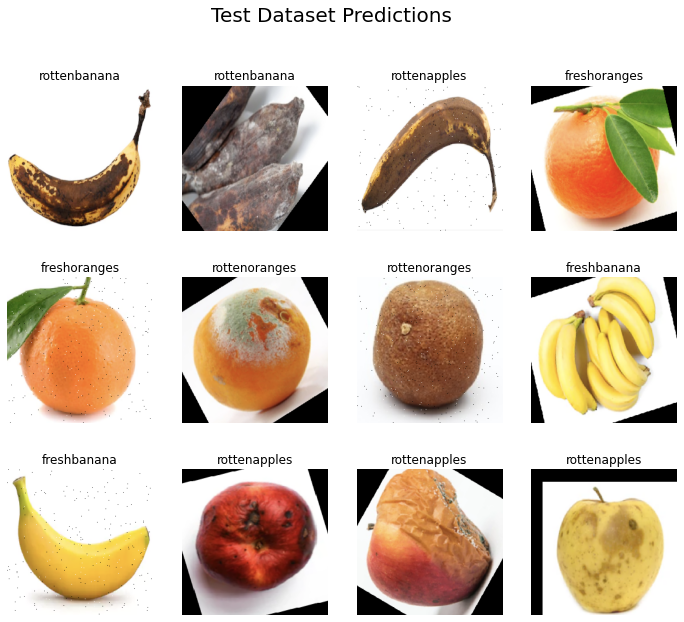

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 10))
idx = 0

for i in range(3):
    for j in range(4):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[idx][0].reshape(240,240,3))
        ax[i, j].axis("off")
        idx += 200

# plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

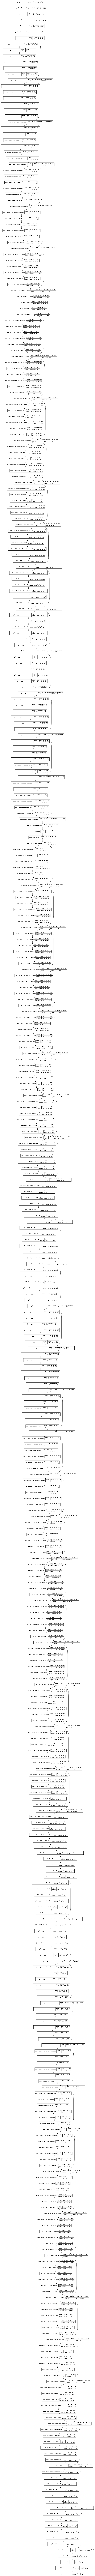

In [18]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [19]:
!pip install visualkeras

ERROR: Could not find a version that satisfies the requirement visualkeras (from versions: none)
ERROR: No matching distribution found for visualkeras


In [20]:
from tensorflow.keras import layers
from collections import defaultdict
# from PIL import ImageFont
# font = ImageFont.truetype("arial.ttf", 12)
color_map = defaultdict(dict) #customize the colours
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
# visualkeras.layered_view(model, legend=True,color_map=color_map,scale_xy=2, scale_z=1, max_z=200)

In [22]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

In [23]:

predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [25]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [26]:
from sklearn.metrics import classification_report,confusion_matrix
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

               precision    recall  f1-score   support

 rottenbanana       1.00      1.00      1.00       530
 freshoranges       0.99      0.98      0.99       388
rottenoranges       0.98      0.98      0.98       403
  freshbanana       1.00      1.00      1.00       381
 rottenapples       0.97      0.98      0.98       601
  freshapples       0.98      0.98      0.98       395

     accuracy                           0.99      2698
    macro avg       0.99      0.99      0.99      2698
 weighted avg       0.99      0.99      0.99      2698



In [27]:
print('Confusion Matrix')
# print(confusion_matrix(test_generator.classes, predicted_classes))
cm = confusion_matrix(test_generator.classes, predicted_classes)

Confusion Matrix


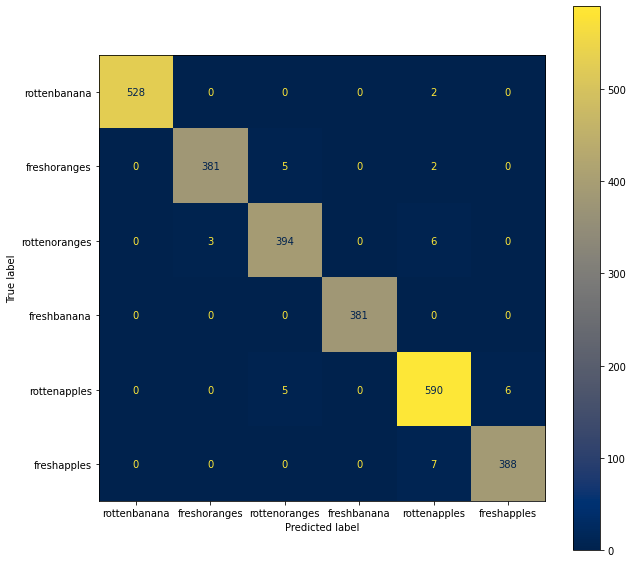

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(test_generator.classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap="cividis")